# Summary

I can use PyMC3 to estimate the posterior PDF for the true skill level of every BUDA team using its W-L record during the season. This could be superior to my initial approach of assuming a discrete skill level based on Division and then modifying that skill level based on individual game outcomes. It will also serve as a great playground in which to explore PyMC3. 

Before I jump in with actual BUDA data, I want to test things out with a small sample of artificial game data.

In [4]:
import pandas as pd
import os
import numpy as np
import pymc3 as pm
from pymc3.math import invlogit
import theano.tensor as tt

%matplotlib inline

In [69]:
n_teams = 67
teams = range(n_teams)

In [70]:
true_skill = {}
for team in teams:
    true_skill[team] = np.random.normal(loc=1600, scale=200)

In [71]:
true_skill

{0: 1726.6796960679646,
 1: 1845.7370689420486,
 2: 1891.2540932116578,
 3: 1271.5057157055066,
 4: 2074.20284947126,
 5: 1467.9664015533353,
 6: 1819.8347570421488,
 7: 1591.539384646029,
 8: 1905.664775826239,
 9: 1637.9124965745566,
 10: 1649.9479715249408,
 11: 1747.1436930456491,
 12: 1574.4571030606078,
 13: 1820.4781306592708,
 14: 1302.3129732530515,
 15: 1549.1067470463497,
 16: 1386.757300589783,
 17: 1793.2834935695093,
 18: 1407.6492159993481,
 19: 1441.159121231951,
 20: 1716.648956037739,
 21: 1519.7851622736468,
 22: 1293.5845564234392,
 23: 1603.4765250293312,
 24: 1664.5898842491479,
 25: 1939.5984496908866,
 26: 1654.5736968515791,
 27: 1745.008791467225,
 28: 1533.532270769773,
 29: 1773.5197602973892,
 30: 1522.333825044672,
 31: 1364.2871769383628,
 32: 1399.2576007930538,
 33: 1945.865275659431,
 34: 1272.4445728300818,
 35: 1464.954558967732,
 36: 1559.794971920905,
 37: 1248.8399668850325,
 38: 1377.8826828485699,
 39: 1129.488812659446,
 40: 1579.3905456399868,

In [72]:
n_games = 520
games = range(n_games)
database = []
for game in games:
    game_database = {}
    matchup = np.random.choice(teams, size=2, replace=False)
    game_database['Team A'] = matchup[0]
    game_database['Team B'] = matchup[1]
    
    true_skills = [true_skill[matchup[0]], true_skill[matchup[1]]]
    game_skills = np.random.normal(loc=true_skills, scale=100)
    
    outcome_A = game_skills[0] > game_skills[1]
    game_database['Winner is A'] = outcome_A
    
    database.append(game_database)
    

In [73]:
game_results = pd.DataFrame(database)

In [74]:
game_results.head(10)

,Team A,Team B,Winner is A
0,43,27,False
1,58,34,True
2,13,57,True
3,19,14,True
4,20,62,False
5,19,42,False
6,58,2,False
7,58,54,True
8,51,4,False
9,0,20,True


In [75]:
project_dir = '/Users/rbussman/Projects/BUDA/buda-ratings'
scores_dir = os.path.join(project_dir, 'data', 'raw', 'game_scores')
game_results.to_csv(os.path.join(scores_dir, 'artificial_scores_big.csv'))

Prior on each team is a normal distribution with mean of 0 and standard deviation of 1.

In [76]:
game_results.shape

(520, 3)

In [77]:
with pm.Model() as model:
    skill = pm.Normal('skill', mu=0, sd=1, shape=n_teams)

    B_minus_A = skill[game_results['Team B'].values] - skill[game_results['Team A'].values]
       
    # Avoid 0 or 1
    lower = 1e-6
    upper = 1 - 1e-6
    probability_A_beats_B = lower + (upper - lower) * 1 / (1 + tt.exp(B_minus_A))
    
    observation = pm.Bernoulli('observation', probability_A_beats_B, observed=game_results['Winner is A'].values)

In [78]:
with model:
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 249.03:   5%|▌         | 10095/200000 [00:01<00:31, 6103.15it/s]
Convergence archived at 10300
Interrupted at 10,300 [5%]: Average Loss = 284.12
100%|██████████| 1500/1500 [00:03<00:00, 474.88it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x149baaa90>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x149c556d0>]], dtype=object)

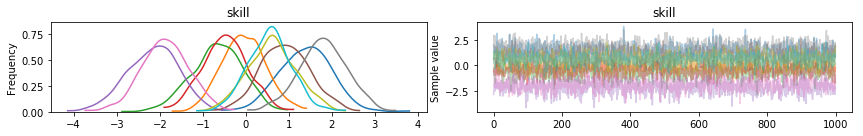

In [64]:
pm.traceplot(trace)

In [65]:
trace.varnames

['skill']

In [79]:
trace['skill'].shape

(1000, 67)

In [80]:
estimatedskills = trace['skill'].mean(axis=0)

In [81]:
for key in true_skill:
    print("True: {:.2f}; Estimated: {:.2f}".format((true_skill[key] - 1600) / 100, estimatedskills[key]))

True: 1.27; Estimated: 1.27
True: 2.46; Estimated: 1.95
True: 2.91; Estimated: 1.48
True: -3.28; Estimated: -1.92
True: 4.74; Estimated: 2.34
True: -1.32; Estimated: 0.21
True: 2.20; Estimated: 1.40
True: -0.08; Estimated: 1.17
True: 3.06; Estimated: 1.28
True: 0.38; Estimated: 0.38
True: 0.50; Estimated: 0.81
True: 1.47; Estimated: 0.59
True: -0.26; Estimated: -0.41
True: 2.20; Estimated: 1.24
True: -2.98; Estimated: -1.32
True: -0.51; Estimated: 0.22
True: -2.13; Estimated: -0.97
True: 1.93; Estimated: 0.59
True: -1.92; Estimated: -0.55
True: -1.59; Estimated: -0.64
True: 1.17; Estimated: 0.49
True: -0.80; Estimated: -0.12
True: -3.06; Estimated: -1.21
True: 0.03; Estimated: 0.36
True: 0.65; Estimated: 1.07
True: 3.40; Estimated: 2.16
True: 0.55; Estimated: 0.77
True: 1.45; Estimated: 1.29
True: -0.66; Estimated: -0.33
True: 1.74; Estimated: 0.83
True: -0.78; Estimated: -0.37
True: -2.36; Estimated: -1.46
True: -2.01; Estimated: -0.48
True: 3.46; Estimated: 2.36
True: -3.28; Estimate

In [22]:
key

2